# AutoML solution vs single model
#### FEDOT version = 0.7.5

In [ ]:
!pip install fedot==0.7.5

Below is an example of running an Auto ML solution for a classification problem.
## Description of the task and dataset

In [46]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import logging
logging.raiseExceptions = False

# Input data from csv files 
train_data_path = '../data/scoring_train.csv'
test_data_path = '../data/scoring_test.csv'
df = pd.read_csv(train_data_path)
df.head(5)

,ID,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30.59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60.89DaysPastDueNotWorse,NumberOfDependents,target
0,0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,1
1,1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0
2,2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0
3,3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0
4,4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,0


## Baseline model

Let's use the api features to solve the classification problem. First, we create a pipeline with a single model "xgboost". 
To do this, we will substitute the appropriate name in the predefined_model field.

Attention!
"predefined_model" - is not an initial assumption for the AutoML algorithm. It's just a single model without AutoML part

In [47]:
from fedot.api.main import Fedot

# task selection, initialisation of the framework
baseline_model = Fedot(problem='classification')

# fit model without optimisation - single XGBoost node is used 
xgb_pipeline = baseline_model.fit(features=train_data_path, target='target', predefined_model='xgboost')

# evaluate the prediction with test data
xgb_predict = baseline_model.predict_proba(features=test_data_path)

2025-09-05 19:00:34,041 - CSV data extraction - Used the column as index: "ID".
2025-09-05 19:00:38,379 - FEDOT logger - Final pipeline: {'depth': 1, 'length': 1, 'nodes': [xgboost]}
xgboost - {'n_jobs': 1, 'verbosity': 0, 'booster': 'gbtree', 'tree_method': 'auto', 'enable_categorical': True, 'use_eval_set': True, 'early_stopping_rounds': 30}
2025-09-05 19:00:38,431 - CSV data extraction - Used the column as index: "ID".


In [48]:
from fedot.core.data.data import InputData
from sklearn.metrics import roc_auc_score

# Read data from csv file as InputData
test_data = InputData.from_csv(test_data_path)
roc_auc_baseline = roc_auc_score(test_data.target, xgb_predict)
roc_auc_baseline

2025-09-05 19:00:38,709 - CSV data extraction - Used the column as index: "ID".


0.8421502333432629

## FEDOT AutoML for classification

We can identify the model using an evolutionary algorithm built into the core of the FEDOT framework.

Here are some parameters that you can specify when initializing a class:
* problem - the name of modelling problem to solve:
        - classification
        - regression
        - ts_forecasting
        - clustering
* seed - value for fixed random seed
* logging_level - level of the output detailing
        - 50 -> critical
        - 40 -> error
        - 30 -> warning
        - 20 -> info
        - 10 -> debug
        - 0 -> nonset
* timeout - time for model design (in minutes)

In [49]:
# new instance to be used as AutoML tool
auto_model = Fedot(problem='classification', seed=42, logging_level=10, timeout=5)

In [50]:
# run of the AutoML-based model generation
pipeline = auto_model.fit(features=train_data_path, target='target')

2025-09-05 19:00:38,870 - CSV data extraction - Used the column as index: "ID".
2025-09-05 19:00:38,918 - DataPreprocessor - -- Converting datetime data to numerical
2025-09-05 19:00:38,924 - DataPreprocessor - -- Fixing table / time series shapes
2025-09-05 19:00:38,929 - DataPreprocessor - -- Finding incorrect features
2025-09-05 19:00:38,933 - DataPreprocessor - --- The number of features with an acceptable nan's percent value was taken 10 / 10
2025-09-05 19:00:38,937 - DataPreprocessor - -- Removing incorrect features
2025-09-05 19:00:38,940 - DataPreprocessor - -- Dropping rows with NaN-values in target
2025-09-05 19:00:38,970 - DataPreprocessor - --- The number of rows with an nan's in target is 0 / 20000
2025-09-05 19:00:38,973 - DataPreprocessor - -- Features types processing
2025-09-05 19:00:39,628 - TableTypesCorrector - --- The detected types of data are as follows: 
Features
	TYPE <class 'bool'> - count 0 - features [] 
	TYPE <class 'float'> - count 10 - features ['Revolvin

In [51]:
prediction = auto_model.predict_proba(features=test_data_path)

# Calculate metric
roc_auc_auto = roc_auc_score(test_data.target, prediction)

2025-09-05 19:06:06,165 - CSV data extraction - Used the column as index: "ID".
2025-09-05 19:06:06,180 - DataPreprocessor - -- Converting datetime data to numerical
2025-09-05 19:06:06,183 - DataPreprocessor - -- Fixing table / time series shapes
2025-09-05 19:06:06,186 - DataPreprocessor - -- Removing incorrect features
2025-09-05 19:06:06,188 - DataPreprocessor - -- Converting data for predict
2025-09-05 19:06:06,349 - DataPreprocessor - Deciding to apply imputation for data
2025-09-05 19:06:06,355 - DataPreprocessor - Finding imputation is required and trying to apply
2025-09-05 19:06:06,381 - DataPreprocessor - --- Initialising imputer
2025-09-05 19:06:06,384 - DataPreprocessor - --- Transforming imputer for missings
2025-09-05 19:06:06,427 - DataPreprocessor - Deciding to apply encoding for data
2025-09-05 19:06:06,430 - DataPreprocessor - Finding encoding is required and trying to apply
2025-09-05 19:06:06,454 - DataPreprocessor - --- Initialising categorical encoder
2025-09-05 

Let see  at the pipeline.

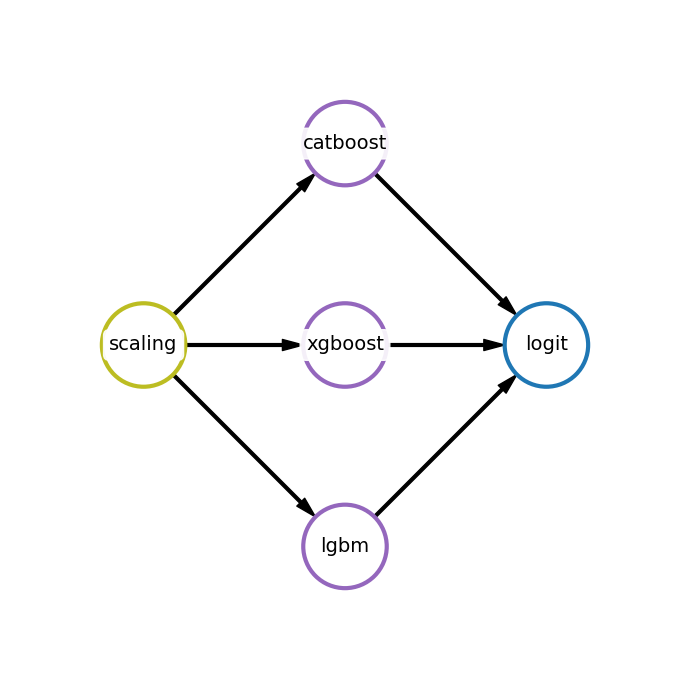

In [52]:
pipeline.show()

In [53]:
# comparison with the manual pipeline

print(f'Baseline {roc_auc_baseline:.2f}')
print(f'AutoML solution {roc_auc_auto:.2f}')

Baseline 0.84
AutoML solution 0.83


Thus, with just a few lines of code, we were able to launch the FEDOT framework and got a better result*.

*Due to the stochastic nature of the algorithm, the metrics for the found solution may differ.

If you want to learn more about FEDOT, you can use [this notebook](2_intro_to_fedot.ipynb).